<a href="https://colab.research.google.com/github/radhakrishnan-omotec/wildlife-repo/blob/main/5_Wildlife_Detection_through_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import pandas as pd
import os
import re
import random
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
from skimage import io
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
from torch.utils.data import (Dataset, DataLoader)  # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from zipfile import ZipFile
file_name = '/content/gdrive/MyDrive/WILDLIFE-PROJECT/INPUT/oregon-wildlife.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
animals_list = os.listdir("/content/oregon_wildlife/oregon_wildlife")
animals_file_list = []

for i in range(len(animals_list)):

  animals_file_list.append(os.listdir(str("/content/oregon_wildlife/oregon_wildlife/" + animals_list[i])))
  n = len(animals_file_list[i])
  print('There are', n , animals_list[i] , 'images.')


There are 726 sea_lions images.
There are 759 red_fox images.
There are 748 bald_eagle images.
There are 728 virginia_opossum images.
There are 588 ringtail images.
There are 577 mountain_beaver images.
There are 764 deer images.
There are 736 coyote images.
There are 735 columbian_black-tailed_deer images.
There are 696 bobcat images.
There are 698 seals images.
There are 660 elk images.
There are 718 black_bear images.
There are 728 raccoon images.
There are 717 canada_lynx images.
There are 668 gray_fox images.
There are 680 cougar images.
There are 701 nutria images.
There are 656 raven images.
There are 730 gray_wolf images.


In [5]:
dir = '/content/oregon_wildlife/oregon_wildlife'
files = [f for f in glob(dir + "**/**", recursive=True)] # create a list will allabsolute path of all files
print("files :" ,len(files))

files : 14034


In [6]:
df_animals = pd.DataFrame({"file_path":files}) # transform in a dataframe
df_animals['animal'] = df_animals['file_path'].str.extract('/oregon_wildlife/(.+)/') # extract the name of the animal
df_animals['file'] = df_animals['file_path'].str.extract('oregon_wildlife/.+/(.+)') # extrat the file name
df_animals = df_animals.dropna() # drop nas
print("dataframe for animals Completed")

dataframe for animals Completed


In [7]:
animal_set = set(df_animals['animal'])
train_val_test_list = [0,1,2]
train_val_weights = [70,15,15]
df_animals['train_val_test'] = 'NA'

for an in animal_set:
  n = sum(df_animals['animal'] == an) # count the number of animals
  train_val_test = random.choices(train_val_test_list, weights= train_val_weights,  k=n)
  df_animals.loc[df_animals['animal'] == an, 'train_val_test'] = train_val_test

print ("Animal Set :" , len(animal_set))

Animal Set : 21


In [8]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

print ("Transform :" , len(transform))

Transform : 3


In [9]:
def check_train(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 0).bool

def check_valid(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 1).bool

def check_test(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 2).bool

In [10]:
# Reading Dataset
image_datasets = {
    'train' : ImageFolder(root= dir, transform=transform['train'], is_valid_file=check_train),
    'valid' : ImageFolder(root=dir, transform=transform['valid'], is_valid_file=check_valid),
    'test' : ImageFolder(root=dir, transform=transform['test'], is_valid_file=check_test)
}

print ("image_datasets :" , len(image_datasets))

image_datasets : 3


In [15]:
num_workers = 0
batch_size = 20

loaders_scratch = {
    'train' : DataLoader(image_datasets['train'], shuffle = True, batch_size = batch_size),
    'valid' : DataLoader(image_datasets['valid'], shuffle = True, batch_size = batch_size),
    'test' : DataLoader(image_datasets['test'], shuffle = True, batch_size = batch_size)
}

print ("loaders_scratch :" , len(loaders_scratch))

loaders_scratch : 3


# TESTING

In [16]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print ("cuda availability : ",use_cuda)

cuda availability :  True


In [17]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224 x 224 x 3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 122 x 122 x 16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56 x 56 x 32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 28 x 28 x 64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 14 x 14 x 128 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)

        # linear layer (64 * 4 * 4 -> 133)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        # linear layer (133 -> 133)
        self.fc2 = nn.Linear(512, 20)


    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.conv_bn2(self.pool(F.relu(self.conv1(x))))
        x = self.conv_bn3(self.pool(F.relu(self.conv2(x))))
        x = self.conv_bn4(self.pool(F.relu(self.conv3(x))))
        x = self.conv_bn5(self.pool(F.relu(self.conv4(x))))
        x = self.conv_bn6(self.pool(F.relu(self.conv5(x))))
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6

Why?

In [15]:

# specify loss function
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

print("optimizer_scratch" , optimizer_scratch)

optimizer_scratch SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    print("Train Start: returns trained model")
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)


        ######################
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)


        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), '/content/gdrive/MyDrive/WILDLIFE-PROJECT/model_scratch_new.pt')
            valid_loss_min = valid_loss

    # return trained model
    return model

# train the model
model_scratch = train(1, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch_new.pt')
print("Train End: returns trained model")

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('/content/gdrive/MyDrive/WILDLIFE-PROJECT/model_scratch_new.pt'))

Train Start: returns trained model


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 1 	Training Loss: 2.613348 	Validation Loss: 2.078884
Validation loss decreased (inf --> 2.078884).  Saving model ...
Train End: returns trained model


<All keys matched successfully>

### LOAD MODEL WITHOUT TRAINING

In [18]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('/content/gdrive/MyDrive/WILDLIFE-PROJECT/model_scratch_wildlife.pt'))

<All keys matched successfully>

In [19]:
print ("model_scratch : " , model_scratch)

model_scratch :  Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

---

### TESTING MODEL WITH IMAGE

Predicted Animal: ELK 
True Animal: elk


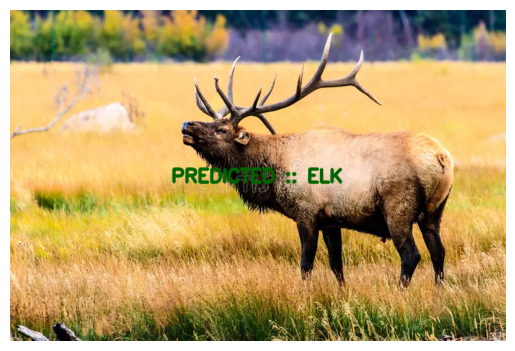

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from torchvision import transforms
from torch.autograd import Variable
import random
import re
from PIL import Image
import numpy as np

# Create a list with class names
class_names = image_datasets['train'].classes
class_names = [re.sub(r"\d{3}\.", "", item) for item in class_names]
class_names = [re.sub("_", " ", item) for item in class_names]

def predict_breed(img):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    img_tensor = preprocess(img).float()
    img_tensor.unsqueeze_(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    img_tensor = Variable(img_tensor) # The input to the network needs to be an autograd Variable

    if use_cuda:
        img_tensor = Variable(img_tensor.cuda())

    model_scratch.eval()
    output = model_scratch(img_tensor) # Returns a Tensor of shape (batch, num class labels)
    output = output.cpu()

    # Our prediction will be the index of the class label with the largest value.
    predict_index = output.data.numpy().argmax()

    predicted_breed = class_names[predict_index]
    true_breed = image_datasets['train'].classes[predict_index]

    return (predicted_breed, true_breed)

# Input image path
image_path = "/content/gdrive/MyDrive/WILDLIFE-PROJECT/elk_image.png"  # Specify the path to your image

# Load the image
img = Image.open(image_path)

predicted_breed, true_breed = predict_breed(img)
print("Predicted Animal:", predicted_breed.upper(), "\nTrue Animal:", true_breed)

# Convert the image to a format that OpenCV can work with
img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Define the text and its properties
text = "PREDICTED :: " + predicted_breed.upper()
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_thickness = 3
text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]

# Calculate the center position for the text
text_x = (img_cv.shape[1] - text_size[0]) // 2
text_y = (img_cv.shape[0] + text_size[1]) // 2

# Define the color (dark green in BGR)
dark_green = (0, 100, 0)

# Overlay the text on the image
cv2.putText(img_cv, text, (text_x, text_y), font, font_scale, dark_green, font_thickness, lineType=cv2.LINE_AA)

# Convert back to RGB for displaying with matplotlib
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')  # Hide axis
plt.show()
